In [1]:
from tifffile import imread
from tqdm import tqdm
from tnia.deeplearning.dl_helper import quantile_normalization
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import transforms
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data
from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap
from semantic_dataset import SemanticDataset
import random
from unet import *
from torch.utils.tensorboard import SummaryWriter
import datetime
from torch.utils.data import DataLoader
from semantic_helper import train

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


In [4]:
from pathlib import Path
import os

tnia_images_path = Path(r"D:\images")
parent_path = r'C:\Users\bnort\Documents\...'

train_path = os.path.join(parent_path, 'patches')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

In [5]:
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel=False, relabel=False)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

Number of input images 400
Number of ground truth images  400
Size of first input image (256, 256, 3)
Size of first ground truth image  (256, 256)


In [6]:
X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, 2, to_numpy=False)

print('Number of training images', len(X_train))
print('Number of validaiton images ', len(X_val))

Number of training images 398
Number of validaiton images  2


In [7]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

X_test = X_val
Y_test = Y_val

X_train.shape, Y_train.shape

((398, 256, 256, 3), (398, 256, 256))

In [8]:
Y_train = Y_train.astype(np.int16)-1
Y_val = Y_val.astype(np.int16)-1
Y_test = Y_test.astype(np.int16)-1

In [9]:
Y_train.min(), Y_train.max()

(-1, 2)

(256, 256, 3) (256, 256)
0.0 1.0
float32 (256, 256, 3) 0.0 1.0


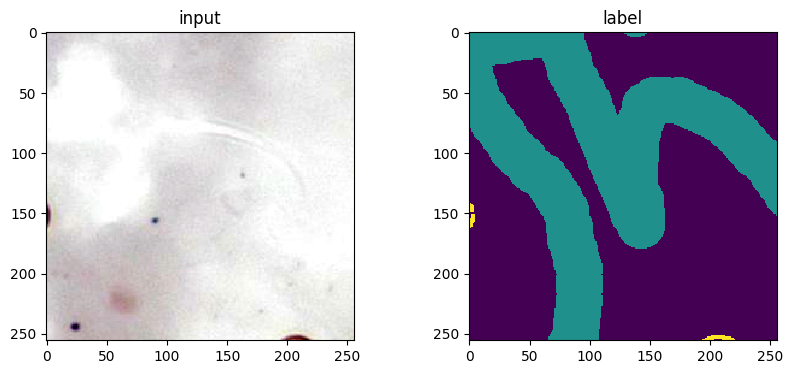

In [10]:
n=10
X_ = X_train[n]
Y_ = Y_train[n]

print(X_.shape, Y_.shape)
print(X_.min(), X_.max())
print(X_.dtype, X_.shape, X_.min(), X_.max())
fig=imshow_multi2d([X_, Y_], ['input', 'label'], 1,2)

In [11]:
train_dataset = SemanticDataset(X_train, Y_train, crop_size=256)
test_dataset = SemanticDataset(X_val, Y_val, crop_size=256)
val_dataset = SemanticDataset(X_val, Y_val, crop_size=256)

In [12]:
raw, mask = train_dataset[random.randrange(len(train_dataset))]
raw = np.transpose(raw, (1,2,0))
raw.shape,mask.shape

((256, 256, 3), (1, 256, 256))

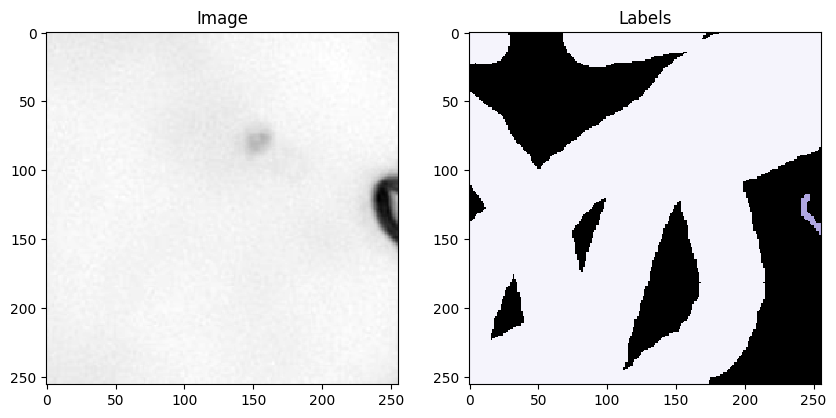

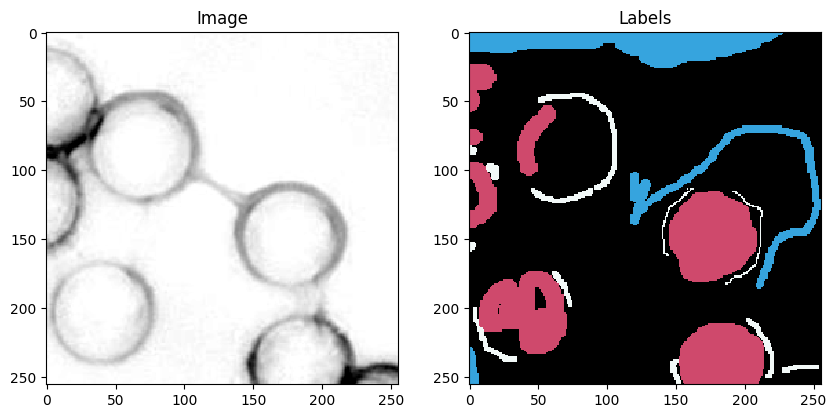

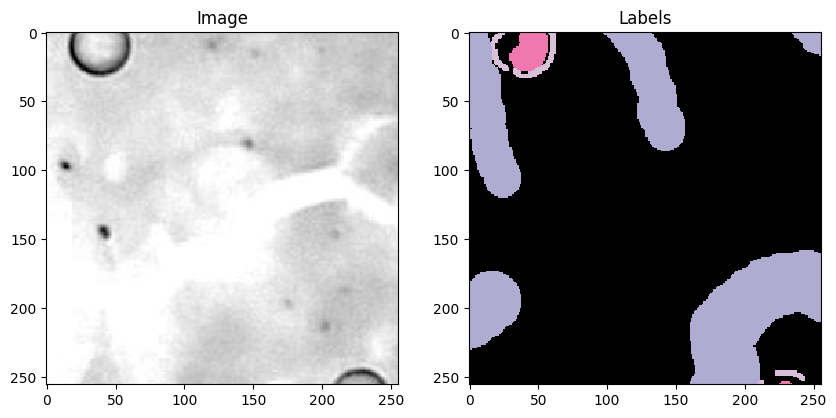

In [13]:
raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])

raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
 
raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])

In [14]:
activation = torch.nn.Softmax(dim=1)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
dtype = torch.LongTensor

d_factors = [[2,2],[2,2],[2,2]]
in_channels=3
num_fmaps=32
fmap_inc_factors=3
padding='same'
final_kernel_size=1
out_channels = 3

unet = UNet(
        in_channels=in_channels,
        num_fmaps=num_fmaps,
        fmap_inc_factors=fmap_inc_factors,
        downsample_factors=d_factors,
        padding=padding)

final_conv = torch.nn.Conv2d(
    in_channels=num_fmaps,
    out_channels=out_channels,
    kernel_size=final_kernel_size)


net = torch.nn.Sequential(unet, final_conv)

from monai.networks.nets import BasicUNet
net2 = BasicUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    #features=[16, 16, 32, 64, 128, 16],
    act="softmax",
    #norm="batch",
    dropout=0.25,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)
net2 = net2.to(device)

loss_fn = loss_fn.to(device)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [17]:
train_batch_size = 4 
test_batch_size = 1

learning_rate = 1e-4
optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

training_steps = 5000

train(train_loader, val_loader, net2, loss_fn, activation, optimizer, dtype, 20000, device, writer)
#

  1%|          | 105/20000 [00:03<10:17, 32.21it/s]

0.0083263405


  1%|          | 205/20000 [00:06<09:58, 33.09it/s]

0.0075394483


  2%|▏         | 305/20000 [00:09<10:11, 32.23it/s]

0.008295028


  2%|▏         | 405/20000 [00:12<10:19, 31.65it/s]

0.010070408


  3%|▎         | 505/20000 [00:15<10:21, 31.38it/s]

0.007057871


  3%|▎         | 605/20000 [00:18<09:50, 32.85it/s]

0.013526915


  4%|▎         | 705/20000 [00:21<09:34, 33.58it/s]

0.0074716094


  4%|▍         | 805/20000 [00:24<09:42, 32.93it/s]

0.007430463


  5%|▍         | 905/20000 [00:27<09:33, 33.28it/s]

0.0071343617


  5%|▌         | 1005/20000 [00:30<09:34, 33.08it/s]

0.0065782303


  6%|▌         | 1105/20000 [00:33<10:15, 30.69it/s]

0.0066210767


  6%|▌         | 1205/20000 [00:36<10:14, 30.60it/s]

0.0060050506


  7%|▋         | 1305/20000 [00:39<09:53, 31.52it/s]

0.0072942064


  7%|▋         | 1405/20000 [00:42<09:26, 32.82it/s]

0.006314165


  8%|▊         | 1505/20000 [00:46<09:53, 31.18it/s]

0.010927639


  8%|▊         | 1605/20000 [00:49<09:36, 31.88it/s]

0.0064992053


  9%|▊         | 1705/20000 [00:52<09:15, 32.92it/s]

0.006974321


  9%|▉         | 1805/20000 [00:55<09:29, 31.96it/s]

0.006691018


 10%|▉         | 1905/20000 [00:58<09:09, 32.92it/s]

0.0077784476


 10%|█         | 2005/20000 [01:01<09:20, 32.10it/s]

0.007379695


 11%|█         | 2105/20000 [01:04<09:38, 30.92it/s]

0.0065820892


 11%|█         | 2205/20000 [01:07<09:19, 31.80it/s]

0.0057541337


 12%|█▏        | 2305/20000 [01:10<08:52, 33.21it/s]

0.005241898


 12%|█▏        | 2405/20000 [01:13<09:05, 32.24it/s]

0.021606196


 13%|█▎        | 2505/20000 [01:16<09:00, 32.38it/s]

0.034935236


 13%|█▎        | 2605/20000 [01:19<09:01, 32.10it/s]

0.0070901536


 14%|█▎        | 2705/20000 [01:22<08:56, 32.26it/s]

0.005791219


 14%|█▍        | 2805/20000 [01:25<08:50, 32.44it/s]

0.004962147


 15%|█▍        | 2905/20000 [01:28<08:47, 32.39it/s]

0.006905617


 15%|█▌        | 3005/20000 [01:31<08:36, 32.91it/s]

0.0069346195


 16%|█▌        | 3105/20000 [01:34<08:35, 32.76it/s]

0.0064953407


 16%|█▌        | 3205/20000 [01:37<08:39, 32.36it/s]

0.0057346886


 17%|█▋        | 3305/20000 [01:41<08:33, 32.49it/s]

0.0062773703


 17%|█▋        | 3405/20000 [01:44<08:39, 31.97it/s]

0.006800282


 18%|█▊        | 3505/20000 [01:47<08:38, 31.78it/s]

0.007503938


 18%|█▊        | 3605/20000 [01:50<08:32, 32.02it/s]

0.006642975


 19%|█▊        | 3705/20000 [01:53<08:45, 31.01it/s]

0.017388375


 19%|█▉        | 3805/20000 [01:56<08:35, 31.39it/s]

0.004220784


 20%|█▉        | 3905/20000 [01:59<08:31, 31.49it/s]

0.005474506


 20%|██        | 4005/20000 [02:02<08:15, 32.29it/s]

0.004799854


 21%|██        | 4105/20000 [02:06<08:34, 30.90it/s]

0.0056706835


 21%|██        | 4205/20000 [02:09<08:08, 32.35it/s]

0.0053134905


 22%|██▏       | 4305/20000 [02:12<08:23, 31.14it/s]

0.0047135


 22%|██▏       | 4405/20000 [02:15<08:22, 31.06it/s]

0.0042148326


 23%|██▎       | 4505/20000 [02:18<08:02, 32.10it/s]

0.0038391533


 23%|██▎       | 4605/20000 [02:21<08:00, 32.05it/s]

0.0037704175


 24%|██▎       | 4705/20000 [02:24<07:50, 32.53it/s]

0.0044802213


 24%|██▍       | 4805/20000 [02:27<07:42, 32.84it/s]

0.0043676333


 25%|██▍       | 4905/20000 [02:30<07:44, 32.47it/s]

0.0043954663


 25%|██▌       | 5005/20000 [02:33<07:46, 32.12it/s]

0.0039641373


 26%|██▌       | 5105/20000 [02:37<07:51, 31.59it/s]

0.0057308557


 26%|██▌       | 5205/20000 [02:40<07:40, 32.12it/s]

0.0045408253


 27%|██▋       | 5301/20000 [02:43<07:28, 32.80it/s]

0.00606966


 27%|██▋       | 5405/20000 [02:46<08:00, 30.40it/s]

0.003211575


 28%|██▊       | 5505/20000 [02:49<07:36, 31.78it/s]

0.0031331736


 28%|██▊       | 5605/20000 [02:52<07:24, 32.35it/s]

0.003905377


 29%|██▊       | 5705/20000 [02:55<07:16, 32.78it/s]

0.005199465


 29%|██▉       | 5805/20000 [02:58<07:25, 31.89it/s]

0.005940235


 30%|██▉       | 5905/20000 [03:02<07:44, 30.31it/s]

0.0058263154


 30%|███       | 6005/20000 [03:05<07:22, 31.60it/s]

0.009100011


 31%|███       | 6104/20000 [03:08<07:44, 29.89it/s]

0.011993989


 31%|███       | 6203/20000 [03:11<07:41, 29.91it/s]

0.0027725291


 32%|███▏      | 6304/20000 [03:15<07:47, 29.28it/s]

0.004444658


 32%|███▏      | 6404/20000 [03:18<07:36, 29.78it/s]

0.002691832


 33%|███▎      | 6504/20000 [03:21<07:26, 30.21it/s]

0.0026026352


 33%|███▎      | 6604/20000 [03:24<07:38, 29.20it/s]

0.002796167


 34%|███▎      | 6705/20000 [03:28<07:22, 30.04it/s]

0.0025866926


 34%|███▍      | 6805/20000 [03:31<07:09, 30.73it/s]

0.002621531


 35%|███▍      | 6904/20000 [03:34<07:20, 29.76it/s]

0.0031203064


 35%|███▌      | 7004/20000 [03:38<07:22, 29.34it/s]

0.0048031956


 36%|███▌      | 7104/20000 [03:41<07:28, 28.74it/s]

0.0026598526


 36%|███▌      | 7202/20000 [03:44<07:33, 28.22it/s]

0.0033633802


 37%|███▋      | 7304/20000 [03:48<07:02, 30.03it/s]

0.0024756347


 37%|███▋      | 7404/20000 [03:51<07:06, 29.56it/s]

0.0030148118


 38%|███▊      | 7506/20000 [03:54<06:53, 30.20it/s]

0.0037364191


 38%|███▊      | 7606/20000 [03:58<06:49, 30.29it/s]

0.0028927098


 39%|███▊      | 7706/20000 [04:01<06:42, 30.58it/s]

0.005954235


 39%|███▉      | 7802/20000 [04:04<06:39, 30.55it/s]

0.0026355926


 40%|███▉      | 7906/20000 [04:07<06:26, 31.25it/s]

0.0057710614


 40%|████      | 8006/20000 [04:10<06:17, 31.78it/s]

0.0029898395


 41%|████      | 8106/20000 [04:14<06:12, 31.93it/s]

0.0046577733


 41%|████      | 8205/20000 [04:17<06:34, 29.91it/s]

0.004584408


 42%|████▏     | 8306/20000 [04:20<06:30, 29.94it/s]

0.0037379232


 42%|████▏     | 8405/20000 [04:23<06:25, 30.05it/s]

0.003917378


 43%|████▎     | 8505/20000 [04:27<06:22, 30.02it/s]

0.004506165


 43%|████▎     | 8604/20000 [04:30<06:33, 28.99it/s]

0.0057817153


 44%|████▎     | 8703/20000 [04:33<06:05, 30.87it/s]

0.002776829


 44%|████▍     | 8803/20000 [04:37<06:15, 29.85it/s]

0.0071964907


 45%|████▍     | 8905/20000 [04:40<05:59, 30.87it/s]

0.003527157


 45%|████▌     | 9005/20000 [04:43<05:49, 31.45it/s]

0.0053044655


 46%|████▌     | 9105/20000 [04:46<05:55, 30.66it/s]

0.0026845671


 46%|████▌     | 9205/20000 [04:49<05:53, 30.56it/s]

0.004288058


 47%|████▋     | 9305/20000 [04:53<05:37, 31.70it/s]

0.0028993117


 47%|████▋     | 9405/20000 [04:56<05:39, 31.17it/s]

0.012370646


 48%|████▊     | 9505/20000 [04:59<05:39, 30.92it/s]

0.0019937286


 48%|████▊     | 9605/20000 [05:02<05:29, 31.57it/s]

0.0046114875


 49%|████▊     | 9704/20000 [05:05<06:05, 28.14it/s]

0.003767581


 49%|████▉     | 9805/20000 [05:09<05:47, 29.32it/s]

0.0042044204


 50%|████▉     | 9905/20000 [05:12<05:09, 32.57it/s]

0.0029147458


 50%|█████     | 10005/20000 [05:15<05:09, 32.24it/s]

0.0027722935


 51%|█████     | 10105/20000 [05:18<05:08, 32.09it/s]

0.002718987


 51%|█████     | 10205/20000 [05:21<05:02, 32.38it/s]

0.002111896


 52%|█████▏    | 10305/20000 [05:25<05:04, 31.81it/s]

0.013079861


 52%|█████▏    | 10406/20000 [05:28<05:25, 29.48it/s]

0.008080458


 53%|█████▎    | 10505/20000 [05:31<05:16, 30.03it/s]

0.0025219708


 53%|█████▎    | 10605/20000 [05:34<05:00, 31.26it/s]

0.0029421784


 54%|█████▎    | 10705/20000 [05:38<04:55, 31.46it/s]

0.0025620265


 54%|█████▍    | 10805/20000 [05:41<05:02, 30.38it/s]

0.0018240276


 55%|█████▍    | 10904/20000 [05:44<05:22, 28.20it/s]

0.0027772482


 55%|█████▌    | 11003/20000 [05:47<05:00, 29.95it/s]

0.0018055378


 56%|█████▌    | 11103/20000 [05:51<05:03, 29.36it/s]

0.0028723057


 56%|█████▌    | 11206/20000 [05:54<04:47, 30.62it/s]

0.0025285634


 57%|█████▋    | 11302/20000 [05:57<04:47, 30.26it/s]

0.005161047


 57%|█████▋    | 11403/20000 [06:00<04:36, 31.04it/s]

0.0021980575


 58%|█████▊    | 11502/20000 [06:03<04:34, 30.98it/s]

0.0020579784


 58%|█████▊    | 11606/20000 [06:07<04:23, 31.85it/s]

0.0023508342


 59%|█████▊    | 11706/20000 [06:10<04:19, 31.98it/s]

0.006647999


 59%|█████▉    | 11804/20000 [06:13<04:36, 29.64it/s]

0.0019593346


 60%|█████▉    | 11904/20000 [06:16<04:27, 30.26it/s]

0.0016415234


 60%|██████    | 12004/20000 [06:20<04:31, 29.48it/s]

0.002083616


 61%|██████    | 12103/20000 [06:23<04:24, 29.83it/s]

0.0014176697


 61%|██████    | 12206/20000 [06:26<04:04, 31.83it/s]

0.0012517875


 62%|██████▏   | 12306/20000 [06:29<04:05, 31.38it/s]

0.0016549511


 62%|██████▏   | 12406/20000 [06:32<04:02, 31.38it/s]

0.0011937234


 63%|██████▎   | 12506/20000 [06:36<03:55, 31.88it/s]

0.0024794661


 63%|██████▎   | 12605/20000 [06:39<03:53, 31.62it/s]

0.002088542


 64%|██████▎   | 12704/20000 [06:42<04:05, 29.71it/s]

0.0015847608


 64%|██████▍   | 12803/20000 [06:45<03:59, 30.05it/s]

0.0032513437


 65%|██████▍   | 12905/20000 [06:49<03:56, 30.04it/s]

0.0011129113


 65%|██████▌   | 13005/20000 [06:52<03:35, 32.48it/s]

0.008401546


 66%|██████▌   | 13105/20000 [06:55<03:36, 31.89it/s]

0.0072425264


 66%|██████▌   | 13205/20000 [06:58<03:35, 31.47it/s]

0.0016917551


 67%|██████▋   | 13305/20000 [07:01<03:28, 32.18it/s]

0.0025097784


 67%|██████▋   | 13404/20000 [07:04<03:42, 29.58it/s]

0.005344929


 68%|██████▊   | 13505/20000 [07:07<03:33, 30.37it/s]

0.003095142


 68%|██████▊   | 13605/20000 [07:11<03:34, 29.76it/s]

0.0010787556


 69%|██████▊   | 13705/20000 [07:14<03:17, 31.90it/s]

0.0016182875


 69%|██████▉   | 13805/20000 [07:17<03:14, 31.88it/s]

0.0011031912


 70%|██████▉   | 13905/20000 [07:20<03:17, 30.83it/s]

0.007122621


 70%|███████   | 14005/20000 [07:23<03:06, 32.13it/s]

0.0018015576


 71%|███████   | 14105/20000 [07:27<03:18, 29.69it/s]

0.0019163219


 71%|███████   | 14203/20000 [07:30<03:12, 30.16it/s]

0.0009850771


 72%|███████▏  | 14303/20000 [07:33<02:59, 31.82it/s]

0.007888814


 72%|███████▏  | 14403/20000 [07:36<02:57, 31.51it/s]

0.0020490657


 73%|███████▎  | 14503/20000 [07:39<02:57, 31.04it/s]

0.006912809


 73%|███████▎  | 14603/20000 [07:42<02:51, 31.43it/s]

0.005184681


 74%|███████▎  | 14703/20000 [07:46<02:52, 30.72it/s]

0.0019561837


 74%|███████▍  | 14806/20000 [07:49<02:53, 29.87it/s]

0.0011616709


 75%|███████▍  | 14905/20000 [07:52<02:50, 29.94it/s]

0.004779123


 75%|███████▌  | 15005/20000 [07:56<02:38, 31.46it/s]

0.004308063


 76%|███████▌  | 15105/20000 [07:59<02:33, 31.93it/s]

0.0012737919


 76%|███████▌  | 15205/20000 [08:02<02:30, 31.94it/s]

0.0009956392


 77%|███████▋  | 15305/20000 [08:05<02:26, 32.11it/s]

0.0010148418


 77%|███████▋  | 15405/20000 [08:08<02:26, 31.44it/s]

0.0020351207


 78%|███████▊  | 15506/20000 [08:12<02:30, 29.83it/s]

0.0018709308


 78%|███████▊  | 15602/20000 [08:15<02:26, 30.12it/s]

0.002482447


 79%|███████▊  | 15705/20000 [08:18<02:15, 31.64it/s]

0.0013042744


 79%|███████▉  | 15805/20000 [08:21<02:10, 32.16it/s]

0.0023241027


 80%|███████▉  | 15905/20000 [08:24<02:08, 31.75it/s]

0.0012307933


 80%|████████  | 16005/20000 [08:27<02:05, 31.85it/s]

0.0040881755


 81%|████████  | 16105/20000 [08:30<02:02, 31.85it/s]

0.0011118647


 81%|████████  | 16204/20000 [08:34<02:09, 29.27it/s]

0.0015911198


 82%|████████▏ | 16304/20000 [08:37<02:09, 28.64it/s]

0.00893968


 82%|████████▏ | 16406/20000 [08:40<01:53, 31.67it/s]

0.0011849802


 83%|████████▎ | 16506/20000 [08:44<01:51, 31.37it/s]

0.0009539288


 83%|████████▎ | 16603/20000 [08:47<01:52, 30.12it/s]

0.0011529925


 84%|████████▎ | 16703/20000 [08:50<01:47, 30.68it/s]

0.001168153


 84%|████████▍ | 16803/20000 [08:53<01:46, 29.97it/s]

0.0012404774


 85%|████████▍ | 16903/20000 [08:57<01:43, 29.86it/s]

0.0015711333


 85%|████████▌ | 17005/20000 [09:00<01:39, 30.11it/s]

0.002291196


 86%|████████▌ | 17105/20000 [09:03<01:33, 31.03it/s]

0.008428103


 86%|████████▌ | 17205/20000 [09:06<01:28, 31.51it/s]

0.012201136


 87%|████████▋ | 17305/20000 [09:10<01:27, 30.91it/s]

0.0009357634


 87%|████████▋ | 17405/20000 [09:13<01:26, 29.89it/s]

0.011524992


 88%|████████▊ | 17504/20000 [09:16<01:20, 30.93it/s]

0.0055544246


 88%|████████▊ | 17606/20000 [09:19<01:19, 30.01it/s]

0.0030040897


 89%|████████▊ | 17701/20000 [09:23<01:24, 27.30it/s]

0.0066363406


 89%|████████▉ | 17806/20000 [09:26<01:10, 31.20it/s]

0.0033209207


 90%|████████▉ | 17906/20000 [09:30<01:07, 31.13it/s]

0.00075428456


 90%|█████████ | 18006/20000 [09:33<01:04, 30.78it/s]

0.0009803171


 91%|█████████ | 18106/20000 [09:36<01:02, 30.38it/s]

0.001898237


 91%|█████████ | 18205/20000 [09:39<00:59, 30.21it/s]

0.00089036784


 92%|█████████▏| 18305/20000 [09:43<00:54, 31.00it/s]

0.00080388866


 92%|█████████▏| 18403/20000 [09:46<01:00, 26.48it/s]

0.00069210684


 93%|█████████▎| 18504/20000 [09:49<00:48, 30.81it/s]

0.0020350877


 93%|█████████▎| 18604/20000 [09:52<00:46, 30.32it/s]

0.001979965


 94%|█████████▎| 18704/20000 [09:56<00:43, 29.54it/s]

0.0035615002


 94%|█████████▍| 18805/20000 [09:59<00:39, 29.97it/s]

0.007991318


 95%|█████████▍| 18905/20000 [10:02<00:36, 30.09it/s]

0.0034324594


 95%|█████████▌| 19005/20000 [10:05<00:32, 30.65it/s]

0.0013202251


 96%|█████████▌| 19105/20000 [10:09<00:29, 30.84it/s]

0.0016742625


 96%|█████████▌| 19205/20000 [10:12<00:26, 30.44it/s]

0.0024033953


 97%|█████████▋| 19304/20000 [10:15<00:23, 29.30it/s]

0.0029501768


 97%|█████████▋| 19405/20000 [10:18<00:20, 29.51it/s]

0.0064715273


 98%|█████████▊| 19506/20000 [10:22<00:16, 30.41it/s]

0.0028826573


 98%|█████████▊| 19606/20000 [10:25<00:12, 30.99it/s]

0.0068648458


 99%|█████████▊| 19704/20000 [10:28<00:10, 27.88it/s]

0.014559524


 99%|█████████▉| 19802/20000 [10:31<00:06, 31.56it/s]

0.003327365


100%|█████████▉| 19906/20000 [10:35<00:03, 31.15it/s]

0.023050716


100%|██████████| 20000/20000 [10:38<00:00, 31.33it/s]

0.007688413


In [26]:

torch.save(net2, Path(model_path) / 'model2')

In [19]:
train(train_loader, val_loader, net2, loss_fn, activation, optimizer, dtype, 20000, device, writer)

  1%|          | 104/20000 [00:03<10:24, 31.86it/s]

0.0005339015


  1%|          | 204/20000 [00:06<10:03, 32.81it/s]

0.0077819303


  2%|▏         | 304/20000 [00:09<10:11, 32.23it/s]

0.0020740228


  2%|▏         | 404/20000 [00:12<10:37, 30.72it/s]

0.0019248989


  3%|▎         | 504/20000 [00:15<10:41, 30.38it/s]

0.0012678553


  3%|▎         | 604/20000 [00:18<10:11, 31.70it/s]

0.0018660228


  4%|▎         | 704/20000 [00:21<10:14, 31.40it/s]

0.001480778


  4%|▍         | 804/20000 [00:24<09:52, 32.42it/s]

0.0013099823


  5%|▍         | 904/20000 [00:28<10:03, 31.65it/s]

0.0044343546


  5%|▌         | 1004/20000 [00:31<09:47, 32.35it/s]

0.0025589943


  6%|▌         | 1104/20000 [00:34<09:56, 31.68it/s]

0.007644831


  6%|▌         | 1204/20000 [00:37<10:29, 29.86it/s]

0.0018669873


  7%|▋         | 1304/20000 [00:40<09:58, 31.26it/s]

0.0017756708


  7%|▋         | 1404/20000 [00:43<09:38, 32.15it/s]

0.0012483186


  8%|▊         | 1504/20000 [00:46<09:48, 31.41it/s]

0.0077092145


  8%|▊         | 1604/20000 [00:49<09:44, 31.49it/s]

0.00096362265


  9%|▊         | 1704/20000 [00:52<09:58, 30.56it/s]

0.002200931


  9%|▉         | 1804/20000 [00:55<09:32, 31.81it/s]

0.0012063575


 10%|▉         | 1904/20000 [00:58<09:44, 30.98it/s]

0.00092561566


 10%|█         | 2004/20000 [01:01<09:42, 30.89it/s]

0.0012557282


 11%|█         | 2104/20000 [01:04<09:29, 31.41it/s]

0.00131581


 11%|█         | 2204/20000 [01:08<09:24, 31.51it/s]

0.00782024


 12%|█▏        | 2304/20000 [01:11<10:05, 29.23it/s]

0.007422624


 12%|█▏        | 2404/20000 [01:14<09:22, 31.28it/s]

0.0011503309


 13%|█▎        | 2504/20000 [01:17<09:30, 30.69it/s]

0.0017759852


 13%|█▎        | 2604/20000 [01:20<09:29, 30.52it/s]

0.0019597164


 14%|█▎        | 2704/20000 [01:23<09:28, 30.42it/s]

0.0006631493


 14%|█▍        | 2804/20000 [01:27<09:30, 30.13it/s]

0.0013237748


 15%|█▍        | 2905/20000 [01:30<09:14, 30.84it/s]

0.0007758464


 15%|█▌        | 3005/20000 [01:33<09:09, 30.90it/s]

0.0009058942


 16%|█▌        | 3105/20000 [01:36<09:06, 30.92it/s]

0.005530302


 16%|█▌        | 3205/20000 [01:40<09:18, 30.07it/s]

0.002190146


 17%|█▋        | 3303/20000 [01:43<09:15, 30.06it/s]

0.002967685


 17%|█▋        | 3403/20000 [01:46<08:48, 31.40it/s]

0.0008486764


 18%|█▊        | 3503/20000 [01:49<09:04, 30.28it/s]

0.0030605795


 18%|█▊        | 3603/20000 [01:52<08:46, 31.16it/s]

0.0012513616


 19%|█▊        | 3706/20000 [01:56<09:10, 29.59it/s]

0.0010029557


 19%|█▉        | 3805/20000 [01:59<08:50, 30.55it/s]

0.0016079235


 20%|█▉        | 3903/20000 [02:02<08:36, 31.18it/s]

0.0006323118


 20%|██        | 4003/20000 [02:05<08:33, 31.14it/s]

0.00086780055


 21%|██        | 4103/20000 [02:08<08:22, 31.65it/s]

0.0007626876


 21%|██        | 4203/20000 [02:11<08:40, 30.35it/s]

0.0009685758


 22%|██▏       | 4303/20000 [02:15<08:56, 29.26it/s]

0.00086528366


 22%|██▏       | 4405/20000 [02:18<08:52, 29.30it/s]

0.0016210023


 23%|██▎       | 4504/20000 [02:21<08:54, 28.97it/s]

0.0031358514


 23%|██▎       | 4603/20000 [02:25<08:53, 28.87it/s]

0.00178686


 24%|██▎       | 4704/20000 [02:28<08:29, 29.99it/s]

0.0010148655


 24%|██▍       | 4804/20000 [02:31<08:32, 29.64it/s]

0.0005490104


 25%|██▍       | 4903/20000 [02:34<08:33, 29.40it/s]

0.0018333218


 25%|██▌       | 5004/20000 [02:38<08:33, 29.20it/s]

0.00089688075


 26%|██▌       | 5106/20000 [02:41<08:10, 30.38it/s]

0.0057561295


 26%|██▌       | 5205/20000 [02:44<08:13, 29.97it/s]

0.0007087659


 27%|██▋       | 5306/20000 [02:48<08:10, 29.96it/s]

0.0022015553


 27%|██▋       | 5405/20000 [02:51<08:05, 30.03it/s]

0.00044722398


 28%|██▊       | 5505/20000 [02:54<08:08, 29.65it/s]

0.0042814445


 28%|██▊       | 5605/20000 [02:58<08:01, 29.90it/s]

0.00041922752


 29%|██▊       | 5705/20000 [03:01<07:53, 30.18it/s]

0.0068037584


 29%|██▉       | 5805/20000 [03:04<07:42, 30.66it/s]

0.00042855908


 30%|██▉       | 5905/20000 [03:07<07:27, 31.47it/s]

0.0010642665


 30%|███       | 6004/20000 [03:11<07:53, 29.55it/s]

0.0047632717


 31%|███       | 6104/20000 [03:14<07:46, 29.80it/s]

0.0007156605


 31%|███       | 6202/20000 [03:17<07:37, 30.18it/s]

0.0015803637


 32%|███▏      | 6303/20000 [03:20<07:51, 29.04it/s]

0.0013873177


 32%|███▏      | 6406/20000 [03:24<07:19, 30.95it/s]

0.014881726


 33%|███▎      | 6505/20000 [03:27<07:41, 29.22it/s]

0.00036667142


 33%|███▎      | 6605/20000 [03:30<07:13, 30.92it/s]

0.001586712


 34%|███▎      | 6705/20000 [03:33<07:11, 30.81it/s]

0.0013711739


 34%|███▍      | 6805/20000 [03:37<07:14, 30.39it/s]

0.0013717973


 35%|███▍      | 6905/20000 [03:40<07:12, 30.27it/s]

0.004047297


 35%|███▌      | 7005/20000 [03:43<07:06, 30.45it/s]

0.0011435526


 36%|███▌      | 7105/20000 [03:47<07:10, 29.97it/s]

0.15284856


 36%|███▌      | 7205/20000 [03:50<07:37, 27.97it/s]

0.0016197726


 37%|███▋      | 7305/20000 [03:53<07:03, 29.94it/s]

0.0003384612


 37%|███▋      | 7404/20000 [03:57<07:11, 29.19it/s]

0.00042744278


 38%|███▊      | 7504/20000 [04:00<06:53, 30.22it/s]

0.0012041405


 38%|███▊      | 7605/20000 [04:03<07:11, 28.73it/s]

0.0011784503


 39%|███▊      | 7706/20000 [04:07<06:47, 30.20it/s]

0.00030243534


 39%|███▉      | 7805/20000 [04:10<06:52, 29.55it/s]

0.0002785548


 40%|███▉      | 7903/20000 [04:13<07:03, 28.57it/s]

0.00552822


 40%|████      | 8006/20000 [04:17<06:44, 29.63it/s]

0.0053173457


 41%|████      | 8106/20000 [04:20<06:22, 31.13it/s]

0.005569273


 41%|████      | 8202/20000 [04:23<06:19, 31.08it/s]

0.0002601999


 42%|████▏     | 8306/20000 [04:27<06:24, 30.44it/s]

0.0005662891


 42%|████▏     | 8405/20000 [04:30<06:28, 29.85it/s]

0.00032050235


 43%|████▎     | 8504/20000 [04:33<06:28, 29.59it/s]

0.00063958776


 43%|████▎     | 8604/20000 [04:36<06:09, 30.87it/s]

0.0003053118


 44%|████▎     | 8704/20000 [04:40<06:17, 29.96it/s]

0.00025561365


 44%|████▍     | 8804/20000 [04:43<05:59, 31.16it/s]

0.00031776467


 45%|████▍     | 8904/20000 [04:46<06:04, 30.45it/s]

0.003511338


 45%|████▌     | 9006/20000 [04:49<06:01, 30.45it/s]

0.0004280276


 46%|████▌     | 9106/20000 [04:53<05:50, 31.04it/s]

0.004683962


 46%|████▌     | 9204/20000 [04:56<06:10, 29.12it/s]

0.0021234627


 47%|████▋     | 9305/20000 [04:59<06:10, 28.86it/s]

0.0035929116


 47%|████▋     | 9404/20000 [05:03<06:01, 29.33it/s]

0.0008087071


 48%|████▊     | 9504/20000 [05:06<05:44, 30.43it/s]

0.00072917464


 48%|████▊     | 9604/20000 [05:09<05:45, 30.09it/s]

0.0026239518


 49%|████▊     | 9703/20000 [05:12<05:47, 29.61it/s]

0.00072530535


 49%|████▉     | 9805/20000 [05:16<06:03, 28.01it/s]

0.00080184615


 50%|████▉     | 9904/20000 [05:19<05:23, 31.19it/s]

0.0005014182


 50%|█████     | 10004/20000 [05:22<05:15, 31.72it/s]

0.000342293


 51%|█████     | 10104/20000 [05:25<05:10, 31.84it/s]

0.00028012536


 51%|█████     | 10204/20000 [05:28<05:14, 31.19it/s]

0.00042529553


 52%|█████▏    | 10304/20000 [05:32<05:06, 31.62it/s]

0.0008010395


 52%|█████▏    | 10403/20000 [05:35<05:10, 30.95it/s]

0.00051656755


 53%|█████▎    | 10503/20000 [05:38<05:13, 30.29it/s]

0.0002948023


 53%|█████▎    | 10603/20000 [05:41<05:05, 30.80it/s]

0.0005005795


 54%|█████▎    | 10703/20000 [05:44<05:07, 30.21it/s]

0.0022205764


 54%|█████▍    | 10803/20000 [05:47<05:00, 30.61it/s]

0.0018471673


 55%|█████▍    | 10903/20000 [05:51<04:57, 30.55it/s]

0.00074182206


 55%|█████▌    | 11003/20000 [05:54<04:50, 30.97it/s]

0.0007397806


 56%|█████▌    | 11103/20000 [05:57<04:50, 30.61it/s]

0.00071285485


 56%|█████▌    | 11203/20000 [06:00<04:53, 30.01it/s]

0.000856505


 57%|█████▋    | 11303/20000 [06:03<04:45, 30.44it/s]

0.0011336372


 57%|█████▋    | 11403/20000 [06:07<04:46, 30.05it/s]

0.00035498635


 58%|█████▊    | 11503/20000 [06:10<04:35, 30.88it/s]

0.0009312846


 58%|█████▊    | 11604/20000 [06:13<04:37, 30.25it/s]

0.0020814815


 59%|█████▊    | 11704/20000 [06:16<04:31, 30.56it/s]

0.0015787437


 59%|█████▉    | 11804/20000 [06:20<04:25, 30.86it/s]

0.004260097


 60%|█████▉    | 11905/20000 [06:23<04:20, 31.03it/s]

0.0007560354


 60%|██████    | 12003/20000 [06:26<04:56, 26.94it/s]

0.0066824537


 61%|██████    | 12106/20000 [06:29<04:12, 31.32it/s]

0.0006140161


 61%|██████    | 12206/20000 [06:32<04:04, 31.90it/s]

0.0004775281


 62%|██████▏   | 12306/20000 [06:36<04:07, 31.09it/s]

0.012900514


 62%|██████▏   | 12402/20000 [06:39<04:08, 30.55it/s]

0.0006902716


 63%|██████▎   | 12506/20000 [06:42<04:08, 30.14it/s]

0.0071522873


 63%|██████▎   | 12606/20000 [06:45<04:00, 30.77it/s]

0.00039838513


 64%|██████▎   | 12706/20000 [06:48<03:51, 31.45it/s]

0.0042382423


 64%|██████▍   | 12806/20000 [06:52<03:50, 31.25it/s]

0.002326008


 65%|██████▍   | 12906/20000 [06:55<03:44, 31.55it/s]

0.0003010662


 65%|██████▌   | 13006/20000 [06:58<03:52, 30.08it/s]

0.0005335846


 66%|██████▌   | 13106/20000 [07:01<03:41, 31.11it/s]

0.0008033848


 66%|██████▌   | 13206/20000 [07:04<03:36, 31.38it/s]

0.00066487107


 67%|██████▋   | 13302/20000 [07:07<03:34, 31.19it/s]

0.0008655783


 67%|██████▋   | 13406/20000 [07:11<03:32, 31.01it/s]

0.00079999364


 68%|██████▊   | 13506/20000 [07:14<03:24, 31.79it/s]

0.001056897


 68%|██████▊   | 13602/20000 [07:17<03:33, 29.94it/s]

0.00058622734


 69%|██████▊   | 13704/20000 [07:21<03:29, 30.10it/s]

0.0007440699


 69%|██████▉   | 13804/20000 [07:24<03:21, 30.82it/s]

0.00094929925


 70%|██████▉   | 13906/20000 [07:27<03:25, 29.58it/s]

0.0008510883


 70%|███████   | 14005/20000 [07:30<03:13, 31.01it/s]

0.0004287113


 71%|███████   | 14105/20000 [07:33<03:08, 31.34it/s]

0.00091827346


 71%|███████   | 14205/20000 [07:37<03:12, 30.17it/s]

0.0010152018


 72%|███████▏  | 14305/20000 [07:40<03:06, 30.52it/s]

0.000501826


 72%|███████▏  | 14405/20000 [07:43<03:06, 30.06it/s]

0.0016827122


 73%|███████▎  | 14504/20000 [07:46<02:53, 31.62it/s]

0.0005429212


 73%|███████▎  | 14604/20000 [07:50<02:53, 31.08it/s]

0.00034276466


 74%|███████▎  | 14704/20000 [07:53<02:56, 29.95it/s]

0.0007024416


 74%|███████▍  | 14805/20000 [07:56<02:47, 30.98it/s]

0.00051848625


 75%|███████▍  | 14905/20000 [07:59<02:47, 30.37it/s]

0.00024055503


 75%|███████▌  | 15005/20000 [08:03<02:40, 31.03it/s]

0.00040919238


 76%|███████▌  | 15105/20000 [08:06<02:36, 31.23it/s]

0.00035739492


 76%|███████▌  | 15204/20000 [08:09<02:40, 29.89it/s]

0.00024894223


 77%|███████▋  | 15304/20000 [08:12<02:57, 26.44it/s]

0.0004683689


 77%|███████▋  | 15405/20000 [08:16<02:26, 31.26it/s]

0.00081462756


 78%|███████▊  | 15504/20000 [08:19<02:30, 29.93it/s]

0.0004834762


 78%|███████▊  | 15604/20000 [08:22<02:20, 31.29it/s]

0.00024257736


 79%|███████▊  | 15704/20000 [08:25<02:19, 30.76it/s]

0.00049227953


 79%|███████▉  | 15805/20000 [08:29<02:26, 28.67it/s]

0.00078056275


 80%|███████▉  | 15904/20000 [08:32<02:13, 30.63it/s]

0.00016805735


 80%|████████  | 16004/20000 [08:35<02:13, 29.97it/s]

0.0005245014


 81%|████████  | 16104/20000 [08:38<02:06, 30.89it/s]

0.0004458741


 81%|████████  | 16204/20000 [08:41<02:07, 29.79it/s]

0.00023086544


 82%|████████▏ | 16304/20000 [08:45<02:02, 30.26it/s]

0.00047266626


 82%|████████▏ | 16404/20000 [08:48<02:01, 29.71it/s]

0.00038139385


 83%|████████▎ | 16503/20000 [08:51<01:52, 31.03it/s]

0.00083692005


 83%|████████▎ | 16603/20000 [08:54<01:51, 30.55it/s]

0.0004718888


 84%|████████▎ | 16703/20000 [08:58<01:47, 30.58it/s]

0.0009206511


 84%|████████▍ | 16803/20000 [09:01<01:46, 30.14it/s]

0.00050790125


 85%|████████▍ | 16903/20000 [09:04<01:41, 30.64it/s]

0.00052913534


 85%|████████▌ | 17003/20000 [09:07<01:40, 29.79it/s]

0.0004936374


 86%|████████▌ | 17103/20000 [09:10<01:33, 30.94it/s]

0.0005540665


 86%|████████▌ | 17203/20000 [09:14<01:31, 30.73it/s]

0.0006701778


 87%|████████▋ | 17303/20000 [09:17<01:25, 31.42it/s]

0.0009098498


 87%|████████▋ | 17403/20000 [09:20<01:26, 30.13it/s]

0.0001824029


 88%|████████▊ | 17503/20000 [09:23<01:20, 30.94it/s]

0.00023975439


 88%|████████▊ | 17603/20000 [09:27<01:20, 29.93it/s]

0.0016756665


 89%|████████▊ | 17706/20000 [09:30<01:14, 30.85it/s]

0.00025810493


 89%|████████▉ | 17806/20000 [09:33<01:11, 30.75it/s]

0.0002853695


 90%|████████▉ | 17902/20000 [09:36<01:09, 30.11it/s]

0.00031459058


 90%|█████████ | 18006/20000 [09:40<01:04, 30.76it/s]

0.0003168458


 91%|█████████ | 18106/20000 [09:43<01:02, 30.28it/s]

0.0006070228


 91%|█████████ | 18206/20000 [09:46<00:58, 30.61it/s]

0.00028826596


 92%|█████████▏| 18306/20000 [09:49<00:55, 30.56it/s]

0.0017248472


 92%|█████████▏| 18406/20000 [09:53<00:51, 30.86it/s]

0.00029815745


 93%|█████████▎| 18506/20000 [09:56<00:49, 30.07it/s]

0.00016784729


 93%|█████████▎| 18605/20000 [09:59<00:44, 31.05it/s]

0.00027854607


 94%|█████████▎| 18705/20000 [10:02<00:42, 30.83it/s]

0.0008121755


 94%|█████████▍| 18805/20000 [10:05<00:38, 30.77it/s]

0.00020731082


 95%|█████████▍| 18905/20000 [10:09<00:35, 30.67it/s]

0.005654671


 95%|█████████▌| 19005/20000 [10:12<00:31, 31.36it/s]

0.0001387127


 96%|█████████▌| 19105/20000 [10:15<00:29, 30.28it/s]

0.00030927168


 96%|█████████▌| 19205/20000 [10:18<00:25, 30.87it/s]

0.0027145543


 97%|█████████▋| 19305/20000 [10:22<00:22, 30.93it/s]

0.001005258


 97%|█████████▋| 19406/20000 [10:25<00:19, 30.18it/s]

0.005653855


 98%|█████████▊| 19506/20000 [10:28<00:15, 31.22it/s]

0.00027436926


 98%|█████████▊| 19606/20000 [10:31<00:12, 31.18it/s]

0.00017568073


 99%|█████████▊| 19706/20000 [10:34<00:09, 30.68it/s]

0.00031598978


 99%|█████████▉| 19806/20000 [10:38<00:06, 31.05it/s]

0.00045955952


100%|█████████▉| 19902/20000 [10:41<00:03, 30.77it/s]

0.00046572956


100%|██████████| 20000/20000 [10:44<00:00, 31.03it/s]

0.0004139674


In [41]:
from skimage.io import imread
im = imread(r'C:\Users\bnort\Documents\bcs-stardist\images\Columbia_Semantic_Sparse\20240910205928_SEP10ERSP2424346.jpg')
im = np.transpose(im, (2,0,1))  
im.shape

#im = im[:,:2048,:2048]

(3, 2076, 3088)

In [42]:
# Visualize predictions
from tnia.deeplearning.dl_helper import quantile_normalization

#im, raw = train_dataset[10]

net2.eval()

print(im.shape, im.min(), im.max())
im = quantile_normalization(im, quantile_low=.05, quantile_high=.95)
im = im.astype(np.float32)
print(im.shape, im.min(), im.max())
im_tensor = torch.from_numpy(im).unsqueeze(0).to(device)       
print(im_tensor.shape)

logits=net2(im_tensor)


(3, 2076, 3088) 52 255
(3, 2076, 3088) 0.0 1.0
torch.Size([1, 3, 2076, 3088])


c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [43]:
im.shape
im = np.transpose(im, (1,2,0))

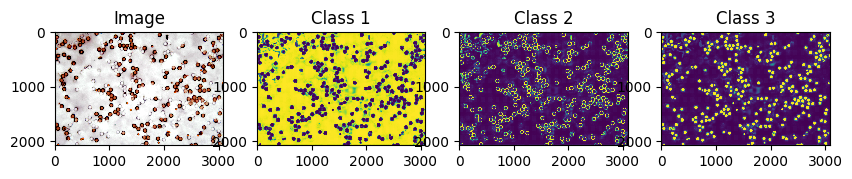

In [44]:
logits.shape
c1 = logits[0,0,:,:].cpu().detach().numpy()
c2 = logits[0,1,:,:].cpu().detach().numpy()
c3 = logits[0,2,:,:].cpu().detach().numpy()

fig = imshow_multi2d([im, c1, c2, c3], ['Image', 'Class 1', 'Class 2', 'Class 3'], 1, 4, 10, 10,colormaps=['gray', 'viridis', 'viridis', 'viridis'])

In [32]:
import napari
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_labels(c1>0)
viewer.add_labels((c2>0)*2)
viewer.add_labels((c3>0)*3)

<Labels layer 'Labels [2]' at 0x1aa949d08b0>